# Calculate daily WBGTmean, WBGTmax, WBGThalf

In [2]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs

from numba import jit
from scipy import stats
from config import DATA_SRC, WEATHER_SRC

import weather_ecmwf

import climate_conversions


In [3]:
RESULTS_FOLDER = Path('./results/lancet2018/global/1.3 labour')


In [2]:
weather = weather_ecmwf.open_mfdataset(WEATHER_SRC / 'ecmwf' / 'daily_sfc',
                                       chunks={'time':100}
                                      )


## Generate Relative Humidity

> We just calculate this in the process of calculating WBT

In [8]:
# relative_humidity = xr.apply_ufunc(climate_conversions.calculate_relative_humidity, 
#                                    weather.temperature_2m, weather.temperature_dewpoint,
#                                    output_dtypes=[np.float],
#                                    dask='parallelized'
#                                   )

# relative_humidity.name = 'relative_humidity'
# relative_humidity = relative_humidity.to_dataset()

In [20]:
# years, datasets = zip(*relative_humidity.groupby('time.year'))
# paths = [WEATHER_SRC / 'ecmwf' / 'daily_rel_humidity'/ f'rel_humidity_{y}.nc' for y in years]
# xr.save_mfdataset(datasets, paths)

## Generate WBT

> Similar to Relative Humidty, can skip if we directly calculate WBGT without saving intermediate data

In [5]:
# wbt = xr.apply_ufunc(climate_conversions.calculate_wbt_t_dew,
#                      weather.temperature_2m,  weather.temperature_dewpoint, weather.surface_pressure,
#                      output_dtypes=[np.dtype(weather.temperature_2m)],
#                      dask='parallelized'
#                     )

# wbt.name = 'wbt'
# wbt = wbt.to_dataset()

In [6]:
# years, datasets = zip(*wbt.groupby('time.year'))
# paths = [WEATHER_SRC / 'ecmwf' / 'daily_wbt'/ f'wbt_{y}.nc' for y in years]
# xr.save_mfdataset(datasets, paths)

## Generate WBGT max, mean

> Again, skip saving intermediate calculation of WBGT for every 6 hours

In [4]:
wbgt = xr.apply_ufunc(climate_conversions.calculate_wbgt_t_dew,
                     weather.temperature_2m,  weather.temperature_dewpoint, weather.surface_pressure,
                     output_dtypes=[np.dtype(weather.temperature_2m)],
                     dask='parallelized'
                    )

wbgt.name = 'wbgt'
wbgt = wbgt.to_dataset()

In [6]:
# years, datasets = zip(*wbgt.groupby('time.year'))
# paths = [WEATHER_SRC / 'ecmwf' / 'test'/ f'wbgt_{y}.nc' for y in years]
# xr.save_mfdataset(datasets, paths)


In [5]:
wbgt_mean = wbgt.resample(time='1D').mean()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="1D").mean() 
  if __name__ == '__main__':


In [7]:
years, datasets = zip(*wbgt_mean.groupby('time.year'))
paths = [WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ f'wbgt_mean_{y}.nc' for y in years]
xr.save_mfdataset(datasets, paths)

In [8]:
wbgt_max = wbgt.resample(time='1D').max()

In [9]:
years, datasets = zip(*wbgt_max.groupby('time.year'))
paths = [WEATHER_SRC / 'ecmwf' / 'daily_wbgtmax'/ f'wbgt_max_{y}.nc' for y in years]
xr.save_mfdataset(datasets, paths)

## Calculate WBGThalf

WBGThalf = the half way point between WBGTmax and WBGTmean.

In [5]:
wbgt_mean = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ 'wbgt_mean_*.nc'),
    chunks={'time':100}
                             )
wbgt_max = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmax'/ 'wbgt_max_*.nc'),
    chunks={'time':100}
)

In [7]:
wbgt_half = wbgt_mean + (wbgt_max - wbgt_mean) / 2

In [8]:
years, datasets = zip(*wbgt_half.groupby('time.year'))
paths = [WEATHER_SRC / 'ecmwf' / 'daily_wbgthalf'/ f'wbgt_half_{y}.nc' for y in years]
xr.save_mfdataset(datasets, paths)

## Some plots

In [4]:
wbgt_mean = xr.open_mfdataset(str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ 'wbgt_mean_*.nc'))

In [5]:
wbgt_baseline = wbgt_mean.wbgt.sel(time=wbgt_mean.time.loc['1986-01-01': '2008-12-31']).groupby('time.dayofyear').mean(dim='time')

In [6]:
def do_day_sub(year_data):
    year_data['time_bak'] = year_data['time']
    year_data['time'] = year_data['time.dayofyear']
    year_data = year_data.rename({'time': 'dayofyear'})
    # rename to align
    delta = year_data - wbgt_baseline
    delta['dayofyear'] = delta['time_bak']
    delta = delta.rename({'dayofyear': 'time'})
    delta = delta.drop('time_bak')
    return delta


wbgt_delta = wbgt_mean.wbgt.groupby('time.year').apply(do_day_sub)

In [7]:
wbgt_delta = wbgt_delta.compute()

In [8]:
from cartopy import crs

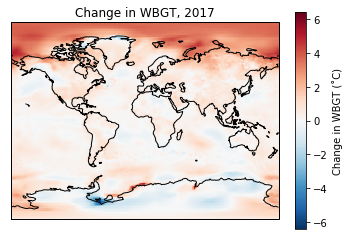

In [32]:
year_vals = wbgt_delta.sel(time=wbgt_delta.time[wbgt_delta.year == 2017]).mean(dim='time')
year_vals.name = 'Change in WBGT (˚C)'

f = plt.figure()
ax = plt.subplot(projection= crs.Miller())
p = year_vals.plot.pcolormesh(
    transform=crs.PlateCarree()
)

ax.coastlines()
plt.title('Change in WBGT, 2017')

plt.savefig(RESULTS_FOLDER / 'wbgt_delta_map_2017.png', dpi=300)

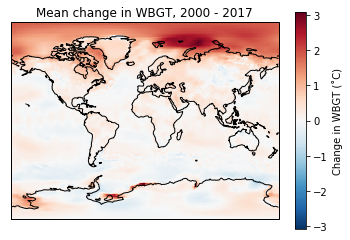

In [44]:
year_vals = wbgt_delta.sel(time=wbgt_delta.time[wbgt_delta.year >=2000]).mean(dim='time')
year_vals.name = 'Change in WBGT (˚C)'

f = plt.figure()
ax = plt.subplot(projection= crs.Miller())
p = year_vals.plot.pcolormesh(
    transform=crs.PlateCarree()
)

ax.coastlines()
plt.title('Mean change in WBGT, 2000 - 2017')

plt.savefig(RESULTS_FOLDER / 'wbgt_delta_map_2000_2017.png', dpi=300)

In [9]:
cos_lat = np.cos(np.radians(wbgt_delta.latitude))

In [10]:
wbgt_delta_ts = (wbgt_delta.groupby('time.year').mean(dim='time') * cos_lat).mean(dim=['latitude', 'longitude']).compute()

In [12]:
import population_tools

In [13]:
wbgt_delta_popweight_ts = population_tools.project_to_population(wbgt_delta.groupby('time.year').mean(dim='time'), norm=True).compute()

Save the data for the line plot

In [17]:
df = wbgt_delta_ts.to_dataframe('wbgt_delta_mean').join(wbgt_delta_popweight_ts.to_dataframe('wbgt_delta_exposure'))
df.to_excel(RESULTS_FOLDER / 'wbgt_delta_yearly_mean.xlsx')

In [14]:
MAX_YEAR = 2017

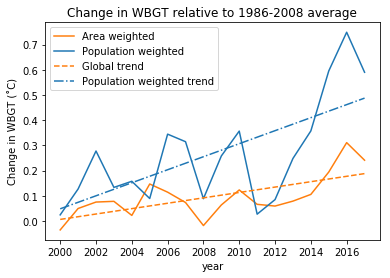

In [18]:
wbgt_delta_ts = wbgt_delta_ts.sel(year=slice(2000,None))
wbgt_delta_ts.plot(color='C1', label='Area weighted')
wbgt_delta_popweight_ts.plot(color='C0', label='Population weighted')


anom_reg = stats.linregress(wbgt_delta_ts.year.values, wbgt_delta_ts.values)
anom_reg = (anom_reg.slope * wbgt_delta_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(wbgt_delta_popweight_ts.year.values, wbgt_delta_popweight_ts.values)
exposures_reg = (exposures_reg.slope * wbgt_delta_popweight_ts.year) + exposures_reg.intercept

anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Population weighted trend')

plt.xticks(list(range(2000, MAX_YEAR + 1, 2)))


plt.ylabel('Change in WBGT (˚C)')
plt.title('Change in WBGT relative to 1986-2008 average')
plt.legend()
plt.savefig(RESULTS_FOLDER / 'wbgt_delta_yearly_mean.png', dpi=300)

In [29]:
wbgt_delta_ts = wbgt_delta.wbgt.mean(dim=['latitude', 'longitude']).compute()

In [ ]:
wbgt_mean_yearly = wbgt_mean.resample(time='1Y').mean()

In [11]:
wbgt_mean_ts = .mean(dim=['latitude', 'longitude']).compute()

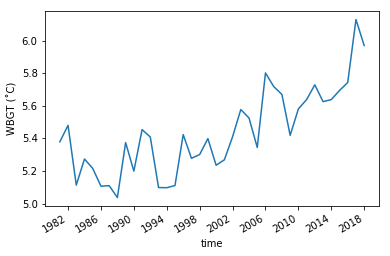

In [6]:
(wbgt_mean_ts.wbgt - 273.15).plot()
plt.ylabel('WBGT (˚C)')
plt.savefig(RESULTS_FOLDER / 'wbgt_yearly_mean.png', dpi=300)

# TODO more accurate method of calculating WBGT


In [ ]:
def fWBGTi(T_air, T_dew):
    # First step Psychrometric Wet bulb temperature calculation
    if T_dew > T_air:
        fWBGTi = T_air
        return fWBGTi

    # Iteration to get Tw from Td       
    Tw = T_dew
    Diff = 10000
    Ed = 0.6106 * np.exp(17.27 * T_dew / (237.3 + T_dew))
    while np.abs(Diff) + np.abs(Diffold) == np.abs(Diff + Diffold):
        Diffold = Diff
        Ew = 0.6106 * np.exp(17.27 * Tw / (237.3 + Tw))
        Diff = 1556 * Ed + 101 * Ta - 1556 * Ew + 1.484 * Ew * Tw - 1.484 * Ed * Tw - 101 * Tw
        Tw = Tw + 0.2
        if Tw > T_air:
            break
        
        if Tw > T_dew + 0.2:
            Tw = Tw - 0.2
        else:
            Tw = T_dew
    # Use Bernard formula to calculate natural wet bulb temperature from psychrometric wet bulb temperature for 1m/s wind speed
    fWBGTi = 0.67 * Tw + 0.33 * T_air
    return fWBGTi